In [4]:
import os
import json
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import bbox_visualizer as bbv
from PIL import Image
import numpy as np
from IPython.display import display
import pandas as pd
import random

In [52]:
def make_coco_dataset(json_path, path_to_images=None, encoding='utf-8'):
    
    with open(json_path, encoding=encoding) as cocojson:
        annotations_json = json.load(cocojson)
        
    # Store the 3 sections of the json as seperate json arrays
    images = pd.json_normalize(annotations_json["images"])
    images.columns = "img_" + images.columns
    try:
        images["img_folder"]
    except:
        images["img_folder"] = ""
    
    # If specified a different image folder then use that one
    if path_to_images != None:
        images["img_folder"] = path_to_images

    astype_dict = {"img_width": "int64", "img_height": "int64", "img_depth": "int64"}
    astype_keys = list(astype_dict.keys())
    for element in astype_keys:
        if element not in images.columns:
            astype_dict.pop(element)
            
    images = images.astype(astype_dict)

    annotations = pd.json_normalize(annotations_json["annotations"])
    annotations.columns = "ann_" + annotations.columns

    categories = pd.json_normalize(annotations_json["categories"])
    categories.columns = "cat_" + categories.columns
    categories.cat_id = categories.cat_id.astype(str)
    
    df = annotations

    # Converting this to string resolves issue #23
    df.ann_category_id = df.ann_category_id.astype(str)

    df[
        ["ann_bbox_xmin", "ann_bbox_ymin", "ann_bbox_width", "ann_bbox_height"]
    ] = pd.DataFrame(df.ann_bbox.tolist(), index=df.index)
    df.insert(8, "ann_bbox_xmax", df["ann_bbox_xmin"] + df["ann_bbox_width"])
    df.insert(10, "ann_bbox_ymax", df["ann_bbox_ymin"] + df["ann_bbox_height"])

    # debug print(df.info())

    # Join the annotions with the information about the image to add the image columns to the dataframe
    df = pd.merge(images, df, left_on="img_id", right_on="ann_image_id", how="left")
    df = pd.merge(
        df, categories, left_on="ann_category_id", right_on="cat_id", how="left"
    )

    # Rename columns if needed from the coco column name to the pylabel column name
    df.rename(columns={"img_file_name": "img_filename"}, inplace=True)
    
    df.fillna('', inplace=True)

    # These should be strings
    df.cat_id = df.cat_id.astype(str)

    # These should be integers
    df.img_width = df.img_width.astype(int)
    df.img_height = df.img_height.astype(int)
    
    return df

In [59]:
def visualize_single_image(dataset, img_path, img_id):
    
    ds = dataset
    ds.cat_id = ds.cat_id.astype('float').astype('Int64') # Optional when the ids are string type

    img_annots = ds.loc[ds.img_id == img_id]
    file_name = img_annots.img_filename.astype(str).values[0]
    image_path = os.path.join(img_path, file_name)
    
    labels = []
    bboxes = []
    
    # Retrieve bboxes and lables from each image
    for index, row in img_annots.iterrows():
        # If there are no annotations, then skip because there are no boxes to draw
        if row["ann_bbox_xmin"] != "":
            labels.append(f"{row['cat_id']}: {row['cat_name']}")
            bboxes.append(
                [
                    int(row["ann_bbox_xmin"]),
                    int(row["ann_bbox_ymin"]),
                    int(row["ann_bbox_xmax"]),
                    int(row["ann_bbox_ymax"]),
                ]
            )
    
    number_of_detections = len(bboxes) 
    
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.putText(img, text=f"# of detections = {number_of_detections}", org=(30,30),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,0,127), thickness=2)
        
    image_with_boxes = img
    
    for bbox in bboxes:
        image_with_boxes = bbv.draw_rectangle(image_with_boxes, bbox, bbox_color=random.sample(range(1, 255), 3))            
        
    img_with_labels = bbv.add_multiple_labels(image_with_boxes, labels, bboxes, top=True)
    display(Image.fromarray(img_with_labels))

In [60]:
coco_json_path = '/home/ubuntu/workspace/datasets/final_dataset/train/annotations/EO-train.json'
coco_image_path = '/home/ubuntu/workspace/datasets/final_dataset/train/EO/image'

In [61]:
coco_dataset = make_coco_dataset(coco_json_path, coco_image_path)
coco_dataset['cat_id'] = coco_dataset['cat_id'].replace('', np.nan)
coco_dataset.head()

img_id                         img_filename  img_license  img_width  \
0       0  2019_11_14_C0001_3922_matrice_0.jpg            1       3840   
1       1  2019_11_14_C0001_3922_matrice_1.jpg            1       3840   
2       2  2019_11_14_C0001_3922_matrice_2.jpg            1       3840   
3       3  2019_11_14_C0001_3922_matrice_3.jpg            1       3840   
4       4  2019_11_14_C0001_3922_matrice_4.jpg            1       3840   

   img_height                                         img_folder ann_id  \
0        2160  /home/ubuntu/workspace/datasets/final_dataset/...    0.0   
1        2160  /home/ubuntu/workspace/datasets/final_dataset/...    1.0   
2        2160  /home/ubuntu/workspace/datasets/final_dataset/...    2.0   
3        2160  /home/ubuntu/workspace/datasets/final_dataset/...    3.0   
4        2160  /home/ubuntu/workspace/datasets/final_dataset/...    4.0   

  ann_image_id ann_category_id ann_segmentation  ... ann_instance_id  \
0          0.0               0               []  ...             0.0   
1          1.0               0               []  ...             0.0   
2          2.0               0               []  ...             0.0   
3          3.0               0               []  ...             0.0   
4          4.0               0               []  ...             0.0   

  ann_bbox_xmax ann_bbox_xmin ann_bbox_ymax ann_bbox_ymin ann_bbox_width  \
0        1420.0        1370.0        1247.0        1213.0           50.0   
1        1420.0        1370.0        1247.0        1213.0           50.0   
2        1420.0        1370.0        1247.0        1213.0           50.0   
3        1420.0        1370.0        1247.0        1213.0           50.0   
4        1420.0        1370.0        1247.0        1213.0           50.0   

  ann_bbox_height cat_id cat_name cat_supercategory  
0            34.0      0    drone                EO  
1            34.0      0    drone                EO  
2            34.0      0    drone                EO  
3            34.0      0    drone                EO  
4            34.0      0    drone                EO  

[5 rows x 23 columns]

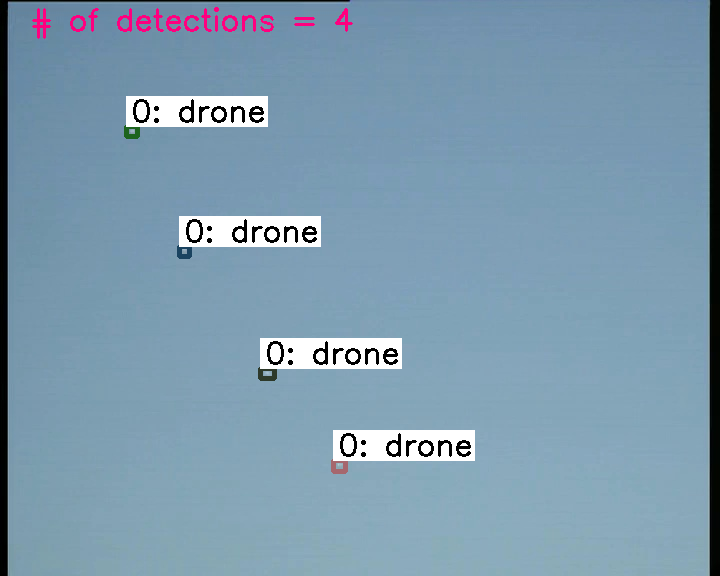

In [68]:
visualize_single_image(coco_dataset, coco_image_path, 60000)